In [1]:
import pandas as pd
import transformers
import numpy as np
from tqdm import tqdm
from sklearn import metrics
import torch
import logging
import warnings

In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.20.0

numpy       : 1.19.2
pandas      : 1.2.2
torch       : 1.8.1+cu111
transformers: 4.4.2



In [3]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
#device = 'cpu'

device

if device == 'cuda':
    gpu_server = True # in case we run the notebook on Colab, set it to False

In [4]:
cuda.is_available()

True

In [5]:
gpu_server

True

In [6]:
if gpu_server == True:
    coarseWSD20    = pd.read_csv('data/data_final_unbalanced.csv')
else:
    coarseWSD20    = pd.read_csv('/content/drive/MyDrive/semcor_belli/senseval_2.csv')
    #senseval_3 = pd.read_csv('/content/drive/MyDrive/semcor_belli/senseval_3.csv')

In [7]:
coarseWSD20.head()

,sent,idx,class
0,the scottish ell was equivalent to : scottish ...,34,yard_yard
1,"the inch , foot , and yard evolved from these ...",6,yard_yard
2,"samuel also returned 63 punt for 673 yard , fo...",7,yard_yard
3,"shaped roughly like a right triangle , the cam...",14,yard_yard
4,"matthews records a playing area of 200 yard , ...",7,yard_yard


In [8]:
coarseWSD20.shape

(33566, 3)

In [9]:
coarseWSD20['class'].value_counts()

pitcher_pitcher                     9209
java_java                           3821
bass_bass_guitar                    3361
java_java_(programming_language)    2612
apple_apple_inc.                    2100
bank_bank                           1494
apple_apple                         1290
bass_bass_(voice_type)               907
spring_spring_(hydrology)            752
spring_spring_(season)               537
seal_pinniped                        436
arm_arm_architecture                 432
bow_bow_(ship)                       383
seal_seal_(emblem)                   379
seal_seal_(musician)                 373
square_square                        367
bass_double_bass                     296
club_club                            294
crane_crane_(machine)                292
bow_bow_and_arrow                    257
pound_pound_(mass)                   247
chair_chairman                       244
deck_deck_(ship)                     244
crane_crane_(bird)                   237
spring_spring_(d

In [10]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import re
import string

import numpy as np
import matplotlib.pyplot as plt #For regular expressions
import math

In [11]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","aren't": "are not",   
                     "can't": "cannot","can't've": "cannot have","'s":"is","'m":"am","'re":"are",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have","'scuse":" excuse" }

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the plots
coarseWSD20['sent']=coarseWSD20['sent'].apply(lambda x:expand_contractions(x))

In [12]:
coarseWSD20['sent']=coarseWSD20['sent'].apply(lambda x: x.lower())
coarseWSD20['sent']=coarseWSD20['sent'].apply(lambda x: re.sub('\w*\d\w*','', x))
coarseWSD20['sent']=coarseWSD20['sent'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

<AxesSubplot:>

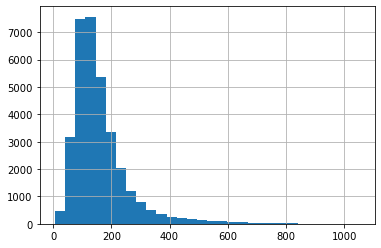

In [13]:
sentences = [len(sent) for sent in coarseWSD20['sent']]
pd.Series(sentences).hist(bins=30)

In [14]:
coarseWSD20['class'] = coarseWSD20['class'].astype('category')
coarseWSD20.dtypes

sent       object
idx         int64
class    category
dtype: object

In [15]:
#data = sens_df.join(pd.DataFrame(labels.toarray(), columns=enc.categories_))
coarseWSD20["target"] = coarseWSD20["class"].cat.codes
#data
new_data = pd.DataFrame()
new_data['text'] = coarseWSD20["sent"]
new_data['labels'] = coarseWSD20["target"]

In [16]:
min_class = new_data['labels'].min()
max_class = new_data['labels'].max()
min_class, max_class

(0, 52)

In [17]:
new_data.head()

,text,labels
0,the scottish ell was equivalent to scottish m...,51
1,the inch foot and yard evolved from these un...,51
2,samuel also returned punt for yard for an a...,51
3,shaped roughly like a right triangle the camp...,51
4,matthews records a playing area of yard with...,51


In [18]:
new_data['labels'].value_counts()

33    9209
26    3821
7     3361
27    2612
1     2100
4     1494
0     1290
6      907
42     752
43     537
37     436
3      432
10     383
38     379
40     373
44     367
8      296
14     294
18     292
11     257
36     247
20     244
13     244
17     237
41     232
45     229
28     225
16     221
51     182
30     164
12     157
2      155
23     152
31     150
50     140
9       98
47      85
22      80
32      76
15      75
29      71
5       68
25      55
49      52
39      50
48      49
24      46
35      36
46      34
52      34
34      31
21      30
19      25
Name: labels, dtype: int64

## BERT BASE UNCASED + 2 LAYER MLP

In [19]:
warnings.simplefilter('ignore')
logging.basicConfig(level=logging.ERROR)

In [20]:
from transformers import RobertaTokenizer

In [21]:
import cv2

In [22]:
 cv2.__version__

'4.5.1'

In [23]:
MAX_LEN = 200
TRAIN_BATCH_SIZE = 4
TEST_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
LEARNING_RATE = 2e-5

tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

In [24]:
from torch.utils.data import Dataset

class MultiLabelDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.labels
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation = True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.long) #long
        }

In [25]:
train_size = 0.75
test_size  = 0.60
train_data = new_data.sample(frac=train_size,random_state=200)
eval_data  = new_data.drop(train_data.index)#.reset_index(drop=True)
test_data  = eval_data.sample(frac=test_size,random_state=200)
val_data   = eval_data.drop(test_data.index)

train_data = train_data.reset_index(drop=True)
test_data  = test_data.reset_index(drop=True)
val_data   = val_data.reset_index(drop=True)



print("FULL Dataset: {}".format(new_data.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))
print("VALIDATION Dataset: {}".format(val_data.shape))

FULL Dataset: (33566, 2)
TRAIN Dataset: (25174, 2)
TEST Dataset: (5035, 2)
VALIDATION Dataset: (3357, 2)


In [26]:
training_set   = MultiLabelDataset(train_data, tokenizer, MAX_LEN)
testing_set    = MultiLabelDataset(test_data, tokenizer, MAX_LEN)
validating_set = MultiLabelDataset(val_data, tokenizer, MAX_LEN)

In [27]:
from torch.utils.data import DataLoader

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': TEST_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

val_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader   = DataLoader(training_set, **train_params)
testing_loader    = DataLoader(testing_set, **test_params)
validating_loader = DataLoader(validating_set, **val_params)

In [28]:
from transformers import RobertaModel

class RoBERTaClass(torch.nn.Module):
    def __init__(self):
        super(RoBERTaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.5)
        #self.classifier_hid = torch.nn.Linear(768, 1512)
        #self.dropout = torch.nn.Dropout(0.5)
        self.classifier = torch.nn.Linear(768, 53)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        #pooler = self.classifier_hid(pooler)
        #pooler = self.dropout(pooler)
        #pooler = torch.nn.ReLU()(pooler)
        output = self.classifier(pooler)
        return output

model = RoBERTaClass()
model.to(device)

RoBERTaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), e

In [29]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples): #scheduler,
    model = model.train() 
    losses = []
    correct_predictions = 0
    
    for _,data in enumerate(data_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)
        
        outputs = model(ids, mask, token_type_ids)
        
        _, preds = torch.max(outputs.data, dim=1) #max
        loss = loss_fn(outputs, targets) # get loss
        
        correct_predictions += torch.sum(preds==targets)
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    scheduler.step()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [30]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval() #Evaluation mode
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for _,data in enumerate(data_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            
            outputs = model(ids, mask, token_type_ids)
            
            _, preds = torch.max(outputs.data, dim=1)
            
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds==targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses) 

In [31]:
import shutil
from collections import defaultdict

def train_model(model, data_loaders_train, data_loader_test, train_sizes, test_sizes, device, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.01) #0.01
    loss_fn   = torch.nn.CrossEntropyLoss().to(device)
    
    history = defaultdict(list)
    best_accuracy = 0
    
    for epoch in range(n_epochs):
        print(f'Epoch {epoch + 1}/{n_epochs}')
        print('-' * 10)
        
        train_acc, train_loss = train_epoch(model, training_loader, loss_fn, 
                                            optimizer, device, scheduler, train_data.shape[0]) #scheduler,
        
        print(f'Train loss {train_loss}, accuracy {train_acc}') #accuracy {train_acc}
        
        val_acc, val_loss = eval_model(model, testing_loader, loss_fn, device, test_data.shape[0])
        
        print(f'Val loss {val_loss}, accuracy {val_acc}') # accuracy {val_acc}
        print()
        
        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)
        
        if val_acc > best_accuracy:
            torch.save(model.state_dict(), 'best_model_state.bin')
            best_accuracy = val_acc
            
    print(f'Best val accuracy: {best_accuracy}')
    
    model.load_state_dict(torch.load('best_model_state.bin'))
    
    return model, history

In [32]:
%%time

base_model, history = train_model(model, training_loader, testing_loader, train_data.shape[0], test_data.shape[0],
                                  device, n_epochs=20)

Epoch 1/20
----------
Train loss 0.45052862876948074, accuracy 0.9026773655358704
Val loss 0.14291753183592243, accuracy 0.9600794438927508

Epoch 2/20
----------
Train loss 0.1315290273691418, accuracy 0.9637721458647811
Val loss 0.1130217493156486, accuracy 0.9686196623634558

Epoch 3/20
----------
Train loss 0.09849836540825238, accuracy 0.9716374036704537
Val loss 0.11112117654061657, accuracy 0.965441906653426

Epoch 4/20
----------
Train loss 0.07844653745989512, accuracy 0.977238420592675
Val loss 0.1457151995760244, accuracy 0.9630585898709036

Epoch 5/20
----------
Train loss 0.06728898113678354, accuracy 0.9816477317867641
Val loss 0.1322965957122627, accuracy 0.9680238331678253

Epoch 6/20
----------
Train loss 0.04737973024179971, accuracy 0.986414554699293
Val loss 0.11707296466762537, accuracy 0.9715988083416087

Epoch 7/20
----------
Train loss 0.03835186315873554, accuracy 0.9892349249225392
Val loss 0.1109604528879721, accuracy 0.9733862959285005

Epoch 8/20
----------

In [33]:
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

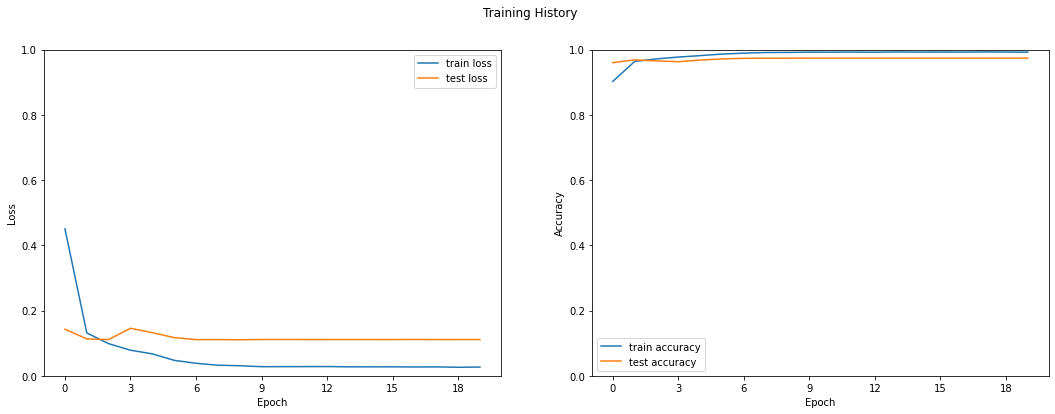

In [34]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
    ax1.plot(history['train_loss'], label='train loss')
    ax1.plot(history['val_loss'], label='test loss')
    
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.set_ylim([0.00,1.00])
    ax1.legend()
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    
    ax2.plot(history['train_acc'], label='train accuracy')
    ax2.plot(history['val_acc'], label='test accuracy')
    
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_ylim([0.00,1.00])
    ax2.legend()
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    
    fig.suptitle('Training History')
    
plot_training_history(history)

In [35]:
from sklearn.metrics import confusion_matrix, classification_report

In [36]:
def get_predictions(model, data_loader):
    model = model.eval()
    predictions = []
    real_values = []
    with torch.no_grad():
        for _,data in enumerate(data_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            
            outputs = model(ids, mask, token_type_ids)
            
            _, preds = torch.max(outputs.data, 1)
            predictions.extend(preds)
            real_values.extend(targets)
    predictions = torch.as_tensor(predictions).cpu()
    real_values = torch.as_tensor(real_values).cpu()
    
    return predictions, real_values

y_pred, y_test = get_predictions(model, validating_loader)

In [37]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       129
           1       1.00      1.00      1.00       203
           2       1.00      1.00      1.00        17
           3       1.00      1.00      1.00        48
           4       1.00      0.98      0.99       154
           5       0.50      1.00      0.67         3
           6       0.93      0.97      0.95        71
           7       0.94      0.96      0.95       321
           8       0.70      0.54      0.61        39
           9       0.80      0.80      0.80        10
          10       1.00      0.97      0.98        30
          11       0.93      0.96      0.95        28
          12       0.91      0.91      0.91        11
          13       0.96      0.96      0.96        24
          14       0.79      0.73      0.76        30
          15       0.88      0.78      0.82         9
          16       0.80      0.88      0.84        32
          17       0.97    